In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()
import math


def get_y(x):
    return 10 + x*x


def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


In [16]:
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

In [17]:

def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3


In [18]:
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])


In [19]:

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)


C:\Users\BEN ALLAL\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\BEN ALLAL\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


ValueError: Variable GAN/Generator/dense/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\Users\BEN ALLAL\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)
  File "C:\Users\BEN ALLAL\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py", line 3561, in _create_op_internal
    ret = Operation(
  File "C:\Users\BEN ALLAL\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "C:\Users\BEN ALLAL\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 1750, in variable_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "C:\Users\BEN ALLAL\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\state_ops.py", line 74, in variable_op_v2
    return gen_state_ops.variable_v2(


In [6]:

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))


In [7]:

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")


In [8]:

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:

# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dloss,gloss))

    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('iteration_%d.png'%i)
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()

Iterations: 0	 Discriminator loss: 0.7079	 Generator loss: 0.7058
Iterations: 1	 Discriminator loss: 0.6851	 Generator loss: 0.7229
Iterations: 2	 Discriminator loss: 0.6602	 Generator loss: 0.7463
Iterations: 3	 Discriminator loss: 0.6329	 Generator loss: 0.7750
Iterations: 4	 Discriminator loss: 0.5951	 Generator loss: 0.8117
Iterations: 5	 Discriminator loss: 0.5630	 Generator loss: 0.8546
Iterations: 6	 Discriminator loss: 0.5244	 Generator loss: 0.9033
Iterations: 7	 Discriminator loss: 0.4875	 Generator loss: 0.9588
Iterations: 8	 Discriminator loss: 0.4491	 Generator loss: 1.0221
Iterations: 9	 Discriminator loss: 0.4079	 Generator loss: 1.1017
Iterations: 10	 Discriminator loss: 0.3604	 Generator loss: 1.2120
Iterations: 11	 Discriminator loss: 0.3184	 Generator loss: 1.3179
Iterations: 12	 Discriminator loss: 0.2742	 Generator loss: 1.4578
Iterations: 13	 Discriminator loss: 0.2310	 Generator loss: 1.6222
Iterations: 14	 Discriminator loss: 0.2016	 Generator loss: 1.7464
Itera

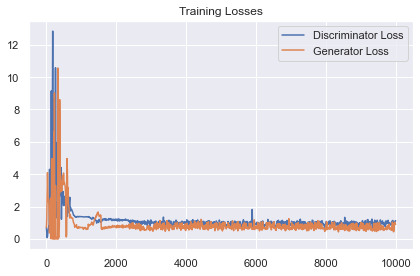

In [14]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
sb.set()


# data = sample_data(n=256)
#
# plt.scatter(data[:,0], data[:,1])

data = pd.read_csv('loss_logs.csv')

plt.plot('Iteration','Discriminator Loss',data=data)
plt.plot('Iteration','Generator Loss',data=data)

plt.legend()
plt.title('Training Losses')
plt.tight_layout()
plt.show()